In [1]:
import uproot
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np
import matplotlib.colors as mcolors
from sklearn.neighbors import KNeighborsClassifier

In [2]:
with uproot.open("../pythia/output/dataset_ttbar_mu60_NumEvents10000_MinJetpT25.root:fastjet") as f:
    jet_pufr = f["jet_pufr_truth"].array()
    jet_corrJVF = f["jet_corrJVF"].array()
    jet_RpT = f["jet_RpT"].array()

In [3]:
jet_pufr = np.array(ak.ravel(jet_pufr))
jet_corrJVF = np.array(ak.ravel(jet_corrJVF))
jet_RpT = np.array(ak.ravel(jet_RpT))

In [4]:
threshold = 0.7

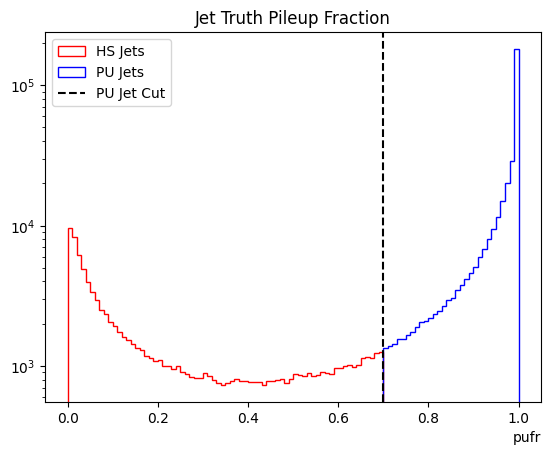

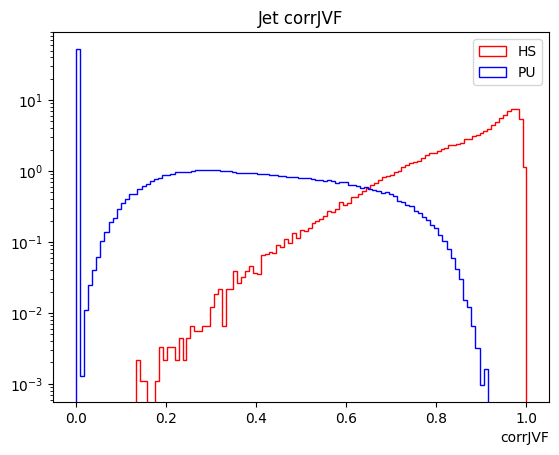

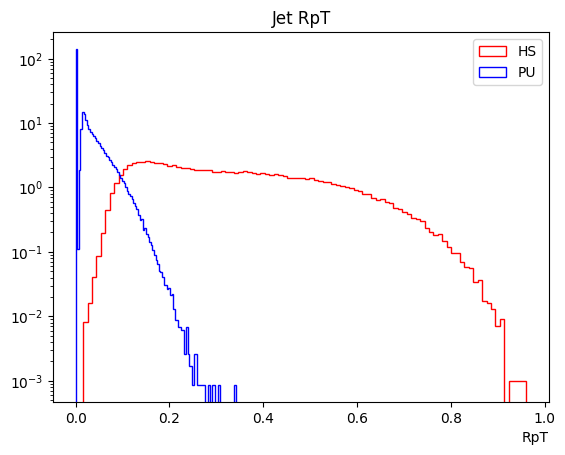

In [5]:
sig = (jet_pufr < threshold)
bkg = ~sig

plt.title("Jet Truth Pileup Fraction")
plt.hist(jet_pufr[jet_pufr<threshold],histtype='step',bins=int(100*threshold),label='HS Jets',color='r')
plt.hist(jet_pufr[jet_pufr>threshold],histtype='step',bins=int(100*(1-threshold)),label='PU Jets',color='b')

plt.axvline(x = threshold, color = 'k', label = 'PU Jet Cut',linestyle='dashed')
plt.xlabel("pufr",loc='right')
plt.legend()
plt.yscale('log')
plt.show()

plt.title("Jet corrJVF")
plt.hist(jet_corrJVF[sig],bins=100,histtype='step',label='HS',density=True,color='r')
plt.hist(jet_corrJVF[bkg],bins=100,histtype='step',label='PU',density=True,color='b')
plt.xlabel("corrJVF",loc='right')
plt.legend()
plt.yscale('log')
plt.show()

plt.title("Jet RpT")
plt.hist(jet_RpT[sig],bins=100,histtype='step',label='HS',density=True,color='r')
plt.hist(jet_RpT[bkg],bins=100,histtype='step',label='PU',density=True,color='b')
plt.xlabel("RpT",loc='right')
plt.legend()
plt.yscale('log')
plt.show()

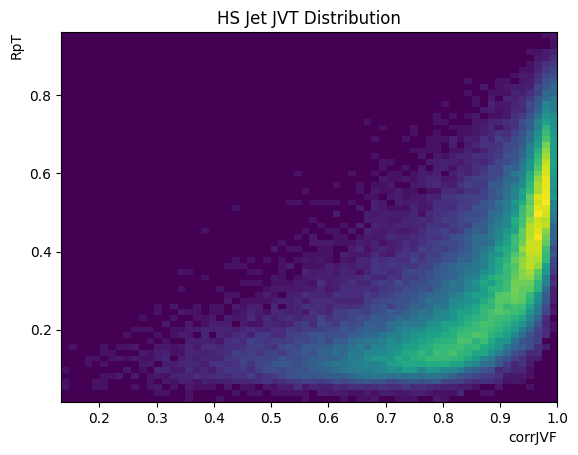

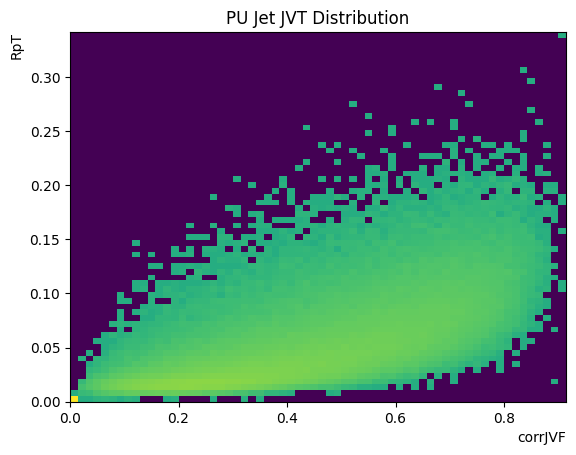

In [6]:
sig = (jet_pufr < threshold)
bkg = ~sig

gamma_sig = 0.5
plt.title("HS Jet JVT Distribution")
plt.hist2d(jet_corrJVF[sig],jet_RpT[sig],bins=64,density=True,norm=mcolors.PowerNorm(gamma_sig))
plt.xlabel("corrJVF",loc='right')
plt.ylabel("RpT",loc='top')
#plt.colorbar()
plt.show()

gamma_bkg = 0.04
plt.title("PU Jet JVT Distribution")
plt.hist2d(jet_corrJVF[bkg],jet_RpT[bkg],bins=64,density=True,norm=mcolors.PowerNorm(gamma_bkg))
plt.xlabel("corrJVF",loc='right')
plt.ylabel("RpT",loc='top')
plt.show()

In [7]:
X = np.vstack((jet_corrJVF,jet_RpT)).T
y = (jet_pufr < threshold).astype(float)

p = np.random.permutation(len(X))
X = X[p]
y = y[p]
jet_pufr = jet_pufr[p]
jet_RpT = jet_RpT[p]
jet_corrJVF = jet_corrJVF[p]

# Total 10k events
num_train = len(X) - 2500

X_train = X[0:num_train]
y_train = y[0:num_train]

X_test = X[num_train:-1]
y_test = y[num_train:-1]

kNN = KNeighborsClassifier(n_neighbors=100)

kNN.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=100)

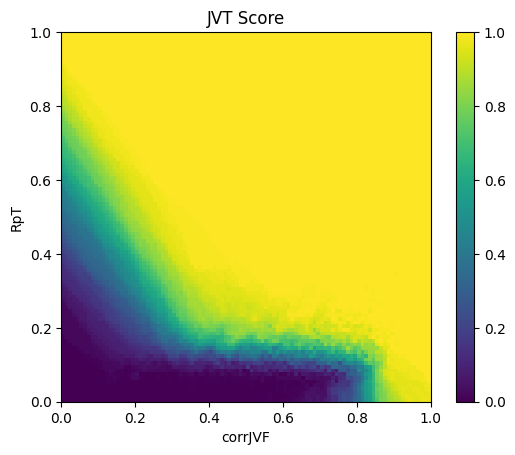

In [8]:
x = np.linspace(0,1,100)
y = np.flip(np.linspace(0,1,100))

xv, yv = np.meshgrid(x,y, copy=True)

zv = np.zeros_like(xv)

for i in range(len(x)):
    for j in range(len(y)):
        zv[j,i] = kNN.predict_proba([[x[i],y[j]]])[:,1][0]
        #print("JVT: ", zv[i,j])
        #print("corrJVF: ", x[i])
        #print("RpT: ", y[j])
        #print()

plt.title("JVT Score")
plt.imshow(zv, extent=[0, 1, 0, 1])

plt.xlabel("corrJVF")
plt.ylabel("RpT")
plt.colorbar()

plt.show()

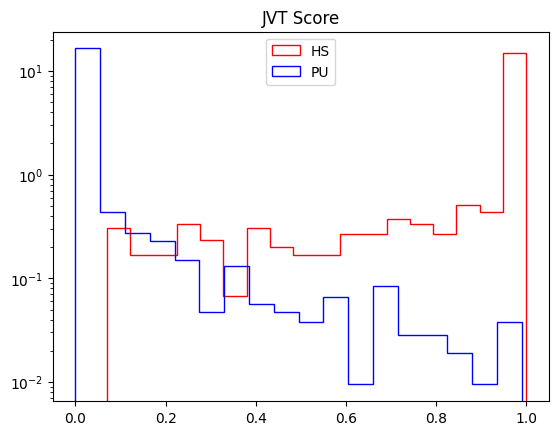

In [9]:
y_pred = kNN.predict(X_test)
y_pred = kNN.predict_proba(X_test)

plt.title("JVT Score")
plt.hist(y_pred[:,1][y_test==1],bins=18,histtype='step',label='HS',density=True,color='r')
plt.hist(y_pred[:,1][y_test==0],bins=18,histtype='step',label='PU',density=True,color='b')
plt.legend(loc='upper center')
plt.yscale('log')
plt.show()